<a href="https://colab.research.google.com/github/nicksonrock/machinelearninguff_rock/blob/main/TCC_ROCK_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predição Machine Learning 

* ## Importando bibliotecas e dados

In [3]:
#UFF Engenharia Mecânica - Projeto de Graduação - Rock Nickson
#Inspiração dos códigos
#https://github.com/shashankgupta1/Assignment-2-/blob/a886684f48282d08a7fc052a5104cc054f320b4f/nasa-turbojet-engine-maintenance.ipynb
#https://www.kaggle.com/code/pkzilli/predicting-failures
#https://www.kaggle.com/code/vinayak123tyagi/damage-propagation-modeling-for-aircraft-engine




import math
import collections
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

# Visualizar Bibliotecas
import seaborn as sns
import matplotlib.pyplot as plt

# Tuning & Splitting Libraries
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Loading Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Model Evaluation Liabraries
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, roc_auc_score, precision_score, recall_score, f1_score

sns.set_style('darkgrid')

In [4]:
# Lendo os dados


jet_data = pd.read_csv('https://raw.githubusercontent.com/nicksonrock/machinelearninguff/main/train_FD001.txt', sep=" ", header=None)
data_test = pd.read_csv('https://raw.githubusercontent.com/nicksonrock/machinelearninguff_rock/main/6.%2BTurbofan%2BEngine%2BDegradation%2BSimulation%2BData%2BSet/6.%20Turbofan%20Engine%20Degradation%20Simulation%20Data%20Set/CMAPSSData/test_FD001.txt',sep=" ",header=None)

jet_data.columns = ["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5"
                    ,"sensor6","sensor7","sensor8","sensor9","sensor10","sensor11","sensor12","sensor13"
                    ,"sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
                    ,"sensor20","sensor21","sensor22","sensor23"]

data_test.columns = ["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5"
                    ,"sensor6","sensor7","sensor8","sensor9","sensor10","sensor11","sensor12","sensor13"
                    ,"sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
                    ,"sensor20","sensor21","sensor22","sensor23"]

jet_data.drop(['sensor22', 'sensor23'], axis=1, inplace=True)
data_test.drop(['sensor22', 'sensor23'], axis=1, inplace=True)

jet_id_and_rul = jet_data.groupby(['id'])[["id" ,"cycle"]].max()
jet_id_and_rul.set_index('id', inplace=True)

In [5]:
#Adicionando a coluna RUL

def RUL_calculator(df, df_max_cycles):
    max_cycle = df_max_cycles["cycle"]
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='id', right_index=True)
    result_frame["RUL"] = result_frame["max_cycle"] - result_frame["cycle"] 
    result_frame.drop(['max_cycle'], axis=1, inplace=True)
    return result_frame

jet_data = RUL_calculator(jet_data, jet_id_and_rul)

In [6]:
jet_data.describe()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,RUL
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,107.807862
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251,68.880990
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,0.000000
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,51.000000
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,103.000000
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,155.000000
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,361.000000


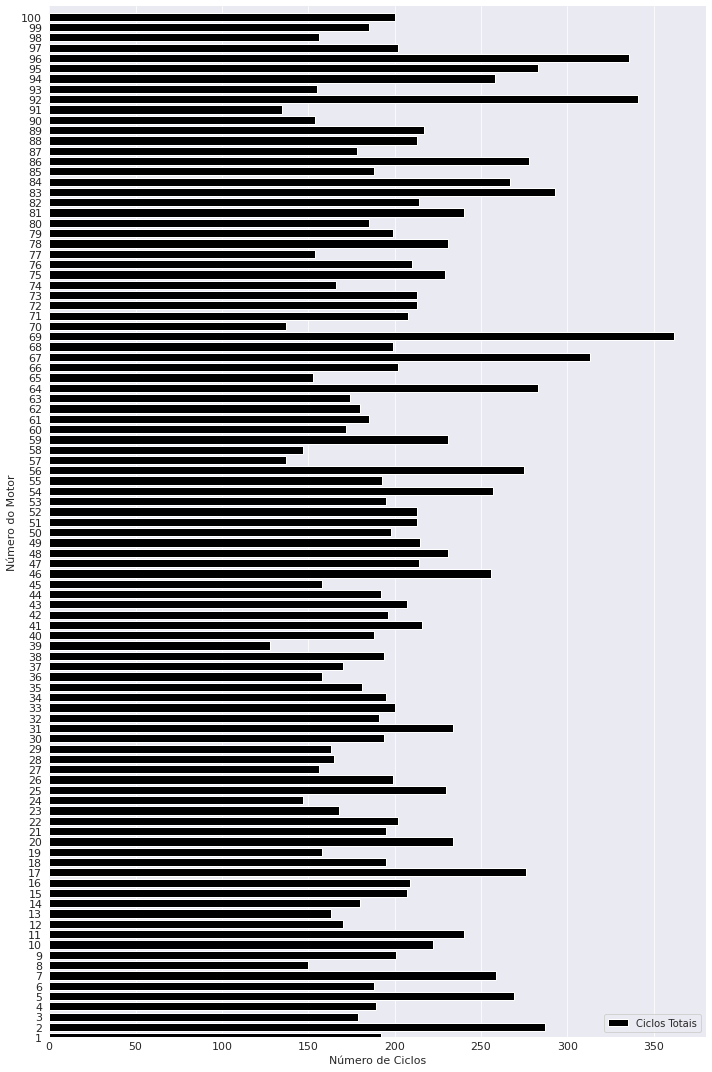

In [7]:
jet_id_and_rul = jet_data.groupby(['id'])[["id" ,"cycle"]].max()

f, ax = plt.subplots(figsize=(10, 15))
sns.set_color_codes("pastel")
sns.barplot(x="cycle", y="id", data=jet_id_and_rul, label="Ciclos Totais", color="black", orient = 'h', dodge=False)
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylim=(0, 100), ylabel="",xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)
ax.tick_params(labelsize=11)
ax.tick_params(length=0, axis='x')
ax.set_ylabel("Número do Motor", fontsize=11)
ax.set_xlabel("Número de Ciclos", fontsize=11)
plt.tight_layout()
plt.show()

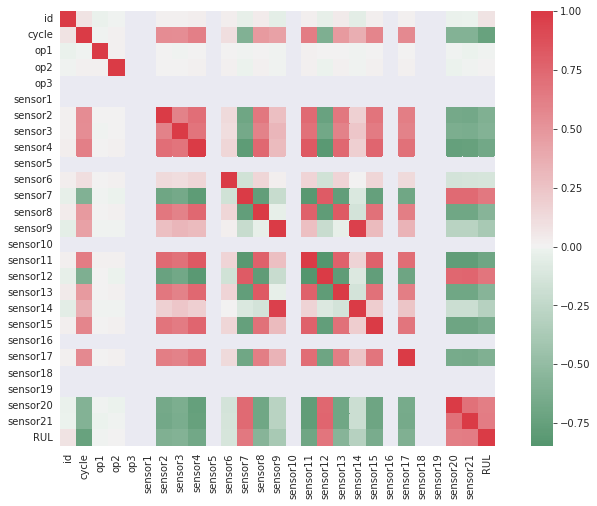

In [8]:
plt.figure(figsize=(13,8))
cmap = sns.diverging_palette(500, 10, as_cmap=True)
sns.heatmap(jet_data.corr(), cmap =cmap, center=0, annot=False, square=True);

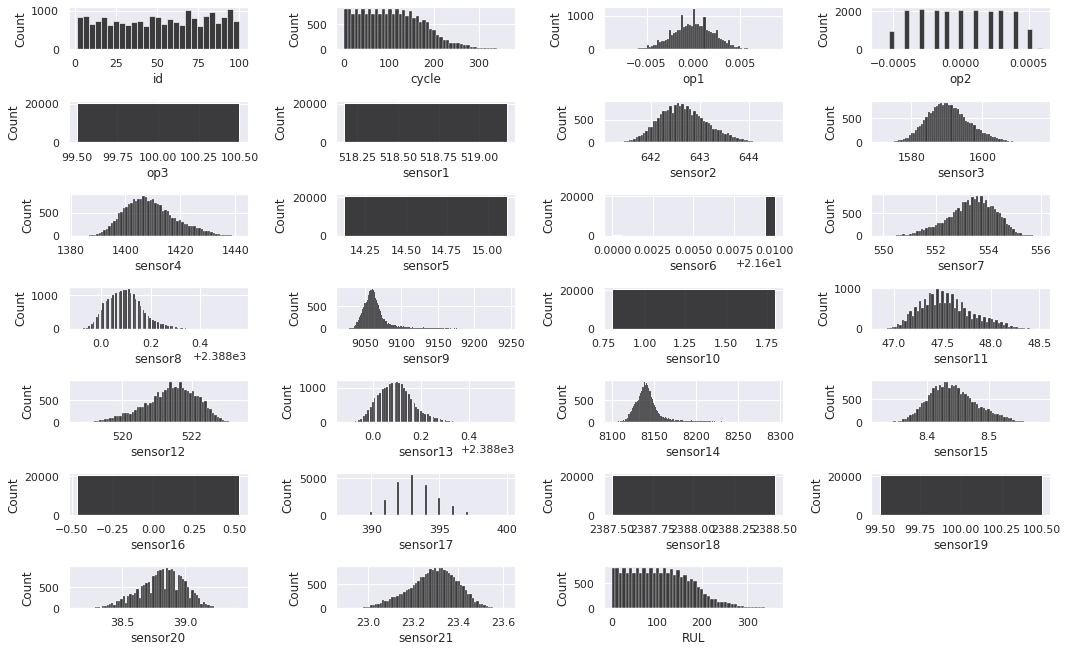

In [9]:
sns.set()
fig = plt.figure(figsize = [15,10])
cols = jet_data.columns
cnt = 1
for col in cols :
    plt.subplot(8,4,cnt)
    sns.histplot(jet_data[col],color='black')
    cnt+=1
plt.tight_layout()
plt.show() 

In [10]:
data_RUL = pd.read_csv('https://raw.githubusercontent.com/nicksonrock/machinelearninguff_rock/main/6.%2BTurbofan%2BEngine%2BDegradation%2BSimulation%2BData%2BSet/6.%20Turbofan%20Engine%20Degradation%20Simulation%20Data%20Set/CMAPSSData/RUL_FD001.txt',sep=" ",header=None)
data_RUL.drop(columns=[1],inplace=True)

In [34]:
jet_data_cycles = jet_data.loc[:, 'id':'cycle']
jet_data_cycles

,id,cycle
0,1,1
1,1,2
2,1,3
3,1,4
4,1,5
...,...,...
20626,100,196
20627,100,197
20628,100,198
20629,100,199


In [12]:
columns_RUL = ['RUL']
data_RUL.columns = columns_RUL
data_RUL.insert(0, 'id', range(1, 1 + len(data_RUL)))
data_RUL

,id,RUL
0,1,112
1,2,98
2,3,69
3,4,82
4,5,91
...,...,...
95,96,137
96,97,82
97,98,59
98,99,117


In [13]:
#sort data unit_ID get maximum cycles

data_test_cycles_MAX = pd.DataFrame(data_test.groupby('id')['cycle'].max()).reset_index()
data_test_cycles_MAX.columns = ['id', 'Qtd. Máx Ciclos']
data_test_cycles_MAX

,id,Qtd. Máx Ciclos
0,1,31
1,2,49
2,3,126
3,4,106
4,5,98
...,...,...
95,96,97
96,97,134
97,98,121
98,99,97


In [14]:
data_test=data_test.merge(data_RUL,on=['id'],how='left')
data_test=data_test.merge(data_test_cycles_MAX,on=['id'],how='left')
data_test['falha']=data_test['Qtd. Máx Ciclos']+data_test['RUL']
data_test

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,RUL,Qtd. Máx Ciclos,falha
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8.4052,0.03,392,2388,100.0,38.86,23.3735,112,31,143
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8.3803,0.03,393,2388,100.0,39.02,23.3916,112,31,143
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8.4441,0.03,393,2388,100.0,39.08,23.4166,112,31,143
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8.3917,0.03,391,2388,100.0,39.00,23.3737,112,31,143
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8.4031,0.03,390,2388,100.0,38.99,23.4130,112,31,143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,8.4715,0.03,394,2388,100.0,38.65,23.1974,20,198,218
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,8.4512,0.03,395,2388,100.0,38.57,23.2771,20,198,218
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,8.4569,0.03,395,2388,100.0,38.62,23.2051,20,198,218
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,8.4711,0.03,395,2388,100.0,38.66,23.2699,20,198,218


In [15]:
#Ordernar dados de id para saber o númeroe máximo de ciculos ou quando a máquina vai falhar 

jet_data_cycles_failure = pd.DataFrame(jet_data.groupby('id')['cycle'].max()).reset_index()
jet_data_cycles_failure.columns = ['id', 'falha']
jet_data_cycles_failure

,id,falha
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269
...,...,...
95,96,336
96,97,202
97,98,156
98,99,185


In [36]:
#Unir falha e RUL em um dataset

jet_data=jet_data.merge(jet_data_cycles_failure,on=['id'],how='left')
jet_data['RUL']=jet_data['falha']-jet_data["cycle"]
jet_data

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23,falha,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,0.03,392,2388,100.0,39.06,23.4190,191,192,192,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,0.03,392,2388,100.0,39.00,23.4236,190,192,192,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,0.03,390,2388,100.0,38.95,23.3442,189,192,192,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,0.03,392,2388,100.0,38.88,23.3739,188,192,192,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,0.03,393,2388,100.0,38.90,23.4044,187,192,192,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,0.03,397,2388,100.0,38.49,22.9735,4,200,200,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,0.03,395,2388,100.0,38.30,23.1594,3,200,200,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,0.03,398,2388,100.0,38.44,22.9333,2,200,200,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,0.03,395,2388,100.0,38.29,23.0640,1,200,200,1


In [17]:
#data test column labelling

columns_test = ["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5"
                    ,"sensor6","sensor7","sensor8","sensor9","sensor10","sensor11","sensor12","sensor13"
                    ,"sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
                    ,"sensor20","sensor21","sensor22","sensor23"]
jet_data.columns = columns_test
jet_data.describe()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,107.807862,216.615724
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251,68.880990,50.028600
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,0.000000,128.000000
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,51.000000,185.000000
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,103.000000,207.000000
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,155.000000,240.000000
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,361.000000,362.000000


In [18]:
# Criando parâmetros X e Y
# Escolher apenas valores que tiveram impacto para a falha dos motores
Selected_features = ['sensor2','sensor3','sensor4','sensor7','sensor11','sensor8','sensor9','sensor13','sensor14','sensor20','sensor21','sensor15','sensor17','sensor12']

X = jet_data[Selected_features]
y = jet_data['cycle']

from sklearn.model_selection import train_test_split

# Dividindo a base em subdados de treino e teste
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)

In [19]:
# Árvore de Decisão
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Define model. Specify a number for random_state to ensure same results each run
Tree_model = DecisionTreeRegressor()

# Fit model
Tree_model.fit(X, y)
Tree_predictions = Tree_model.predict(X_valid)

#Evaluate Model Performance
print('Acurácia do Treino :', Tree_model.score(X_train, y_train))

# Avaliando o erro
print('Erro:', mean_absolute_error(y_valid, Tree_predictions))
print('Erro Quadrático Médio:', mean_squared_error(y_valid, Tree_predictions)) 

Acurácia do Treino : 1.0
Erro: 0.0
Erro Quadrático Médio: 0.0


In [20]:
#Método Random Forest

from sklearn.ensemble import RandomForestRegressor

Forest_model = RandomForestRegressor(n_estimators=225, random_state=0)
Forest_model.fit(X_train, y_train)
Forest_predictions = Forest_model.predict(X_valid)

#Evaluate Model Performance
print('Acurácia do Treino :', Forest_model.score(X_train, y_train))


# Avaliando o erro
print('Erro:', mean_absolute_error(y_valid, Forest_predictions))
print('Erro Quadrático Médio:', mean_squared_error(y_valid, Tree_predictions)) 

Acurácia do Treino : 0.9456673589081082
Erro: 33.72979449398992
Erro Quadrático Médio: 0.0


In [21]:
# Método KNN

from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors = 3)
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_valid)

#Avaliando a Performance do Modelo
print('Acurácia do Treino :', knn_model.score(X_train, y_train))

# Avaliando o erro
print('error:', mean_absolute_error(y_valid, knn_predictions))
print('Erro Quadrático Médio:', mean_squared_error(y_valid, knn_predictions))

Acurácia do Treino : 0.33852517288179407
error: 48.38076773943389
Erro Quadrático Médio: 3993.9546335789064


In [22]:
# Criando as seleções de X e Y para treino e teste

Selected_features_test =  ['sensor2','sensor3','sensor4','sensor7','sensor11','sensor8','sensor9','sensor13','sensor14','sensor20','sensor21','sensor15','sensor17','sensor12']
X_test = jet_data[Selected_features_test]
y_test = jet_data['cycle']

In [23]:
#Teste do Modelo com Random Forest

Forest_model_test = RandomForestRegressor(n_estimators=225, random_state=0)
Forest_model_test.fit(X_test, y_test)
Forest_test_predictions = Forest_model.predict(X_test)

In [24]:
# Predição dos ciclos e exportar para um csv

output_test = pd.DataFrame({'id': jet_data.id,
                       'Ciclos': y_test})
output_test.to_csv('test_ciclos.csv', index=False)
output_test

,id,Ciclos
0,1,1
1,1,2
2,1,3
3,1,4
4,1,5
...,...,...
20626,100,196
20627,100,197
20628,100,198
20629,100,199


In [25]:
#Ordernar os dados de id para encontrar o máximo numero de ciclos 

output_test_cycles_MAX = pd.DataFrame(output_test.groupby('id')['Ciclos'].max()).reset_index()
output_test_cycles_MAX.columns = ['id', 'Qtd Máx. Ciclos']

# predictions cycle MAX output data_test
output_test_cycles_MAX.to_csv('cycles_MAX_test.csv', index=False)
output_test_cycles_MAX

,id,Qtd Máx. Ciclos
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269
...,...,...
95,96,336
96,97,202
97,98,156
98,99,185


In [33]:
jet_data

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,192
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,192
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,192
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,192
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4,200
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3,200
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2,200
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1,200


In [38]:
jet_data

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23,falha,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,0.03,392,2388,100.0,39.06,23.4190,191,192,192,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,0.03,392,2388,100.0,39.00,23.4236,190,192,192,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,0.03,390,2388,100.0,38.95,23.3442,189,192,192,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,0.03,392,2388,100.0,38.88,23.3739,188,192,192,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,0.03,393,2388,100.0,38.90,23.4044,187,192,192,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,0.03,397,2388,100.0,38.49,22.9735,4,200,200,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,0.03,395,2388,100.0,38.30,23.1594,3,200,200,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,0.03,398,2388,100.0,38.44,22.9333,2,200,200,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,0.03,395,2388,100.0,38.29,23.0640,1,200,200,1


In [46]:
# Definindo o modelo
import numpy as np
Selected_features = ['sensor2','sensor3','sensor4','sensor7','sensor11','sensor8','sensor9','sensor13','sensor14','sensor20','sensor21','sensor15','sensor17','sensor12']

X = jet_data[Selected_features]
y = jet_data['falha']

Forest_model_train = RandomForestRegressor(n_estimators=225, random_state=0)
Forest_model_train.fit(X, y)
Forest_train_predictions = Forest_model.predict(X)

train_output = pd.DataFrame({'id': jet_data.id,
                       'falha': Forest_train_predictions})
train_output.to_csv('submission_train.csv', index=False)
train_output = pd.DataFrame(train_output.groupby('id')['falha'].max()).reset_index()
train_output['Tempo para Manutenção']=train_output['falha']*0.8
train_output['Tempo para Manutenção']=train_output['Tempo para Manutenção'].apply(np.ceil)
train_output

,id,falha,Tempo para Manutenção
0,1,191.466667,154.0
1,2,267.351111,214.0
2,3,215.000000,172.0
3,4,209.106667,168.0
4,5,255.391111,205.0
...,...,...,...
95,96,295.608889,237.0
96,97,216.382222,174.0
97,98,216.982222,174.0
98,99,234.537778,188.0


In [43]:
jet_data['falha']

0        192
1        192
2        192
3        192
4        192
        ... 
20626    200
20627    200
20628    200
20629    200
20630    200
Name: falha, Length: 20631, dtype: int64